In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [51]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.PGAN_model.PGAN import PGAN

import torch
import pytorch_lightning as pl
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

In [52]:
# # hyperparameters
# z_dim = 100
latent_dim = 100
batch_size = 32
depths = [256, 256, 128, 64, 32, 16]
num_epochs = 60
num_epochs_per_resolution = int(num_epochs / len(depths))
learning_rate = 0.001
# beta1 = 0.5

# base_directory = "../data/raw/nsynth-train/audio"
base_directory = "../data/raw/Bass"

dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [54]:
dataiter = iter(dataloader)
spectrograms = next(dataiter)
spectrograms.shape

torch.Size([32, 1, 256, 160])

In [55]:
Music_PGAN = PGAN(depths=depths)

In [56]:
Music_PGAN.train(dataloader=dataloader, fade_in_percentage=0.5)

Resolution 0 - Epoch 1/10 - D Loss: 0.28982681035995483 - G Loss: 0.30832985043525696
Resolution 0 - Epoch 2/10 - D Loss: 0.42231616377830505 - G Loss: 0.609529435634613
Resolution 0 - Epoch 3/10 - D Loss: 0.42727130651474 - G Loss: 0.7056975960731506
Resolution 0 - Epoch 4/10 - D Loss: 0.36089763045310974 - G Loss: 0.36344805359840393
Resolution 0 - Epoch 5/10 - D Loss: 0.34572166204452515 - G Loss: 0.5752331018447876
Resolution 0 - Epoch 6/10 - D Loss: 0.4115435481071472 - G Loss: 0.3128238618373871
Resolution 0 - Epoch 7/10 - D Loss: 1.2366547584533691 - G Loss: 1.1394896507263184
Resolution 0 - Epoch 8/10 - D Loss: 0.47415322065353394 - G Loss: 0.2922796905040741
Resolution 0 - Epoch 9/10 - D Loss: 0.4807911515235901 - G Loss: 0.28817516565322876
Resolution 0 - Epoch 10/10 - D Loss: 0.4238922595977783 - G Loss: 0.3051629066467285
Resolution 1 - Epoch 1/10 - D Loss: 0.43963688611984253 - G Loss: 0.36616063117980957
Resolution 1 - Epoch 2/10 - D Loss: 0.38371893763542175 - G Loss: 0.

In [57]:
Music_PGAN.writer.close()

In [58]:
Music_PGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
        (3): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
        (3): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): ModuleList(

In [59]:
z = torch.randn(1, Music_PGAN.latent_dim).to(Music_PGAN.device)
generated_spectrogram = Music_PGAN.generator(z)

In [60]:
spectrogram = generated_spectrogram.cpu().detach().numpy()
spectrogram = spectrogram.squeeze()

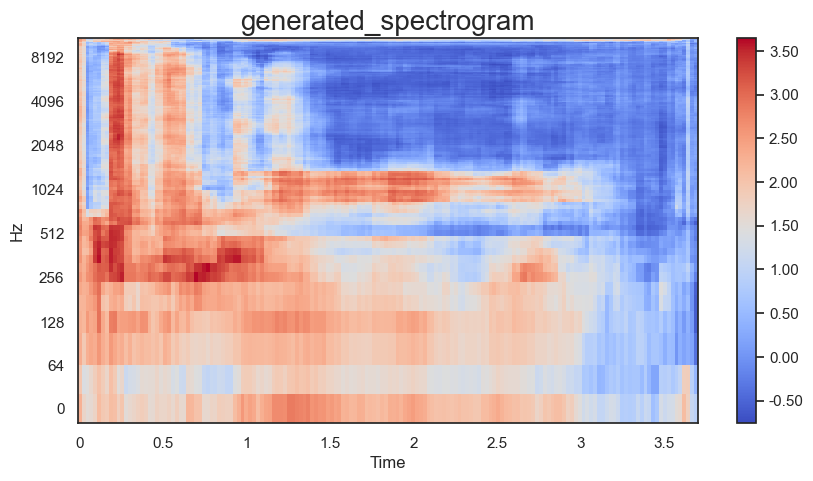

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='log')
plt.title('generated_spectrogram', fontsize=20)
plt.colorbar(img, format='%0.2f')

plt.show()

In [62]:
audio = librosa.feature.inverse.mel_to_audio(spectrogram)

path = '../models/generated_samples/'
file_name = 'PGAN_generated_audio.wav'

sf.write(path + file_name, audio, 22050)